In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.calibration import calibration_curve
import torch 
import torch.nn as nn
import torch.nn.functional as F
import pickle
import yaml

import sys
sys.path.append("../")
from models import DiscreteNAM, NAM
from utils import discretize, get_dataset, get_bin_counts, get_discetized_run_data, get_run_data, get_pair_bin_counts

sys.path.append("../run_scripts")
from epoch_functions import train_epoch_nam_pairs, test_epoch_nam_pairs

In [3]:
def get_shape_fn_discrete_nam_(col, dataset, seed, split, kw0=False):
    
    # Read in model
    
    if kw0:
        model = torch.load(f"../model_saves/discrete_nam_{dataset}_seed{seed}_split{split}_kw0_1.pt")
    else:
        model = torch.load(f"../model_saves/discrete_nam_{dataset}_seed{seed}_split{split}.pt")
    
    # Read in args using yaml
    args_id = model.params_id
    with open(f"../run_parameters/discrete_nam_{dataset}_seed{seed}_split{split}_params{args_id}.yaml", "r") as f:
        args = yaml.safe_load(f)
    
    
    data_dict = \
        get_discetized_run_data(dataset, seed=seed, split=split, max_bins=args["max_bins"], use_feature_set=False)
        
    X_train_discrete = data_dict["X_train_discrete"]
    n_bins = data_dict["n_bins"]
    feature_bins = data_dict["feature_bins"]
        
    bin_counts = [
        get_bin_counts(X_train_discrete[col], nb) for col, nb in zip(X_train_discrete.columns, n_bins)
    ]

    # Compute intercept to center the shape functions
    model.compute_intercept(bin_counts)

    col_index = X_train_discrete.columns.get_loc(col)

    feat_bin_scores = model.get_bin_scores(feat_index=col_index, center=True).squeeze(-1).cpu().numpy()

    # 1: to remove the missing bin
    feat_bin_scores = feat_bin_scores[1:]

    # Prepend the minimum value of the feature for plotting purposes
    feat_bin_values = np.concatenate([
        [feature_bins[col_index].min() - 0.01],
        feature_bins[col_index]
    ])
    
    return model, feat_bin_values, feat_bin_scores

In [4]:
def get_shape_fn_discrete_nam(col, dataset, seed, kw0=False):
    
    splits = [1, 2, 3, 4, 5]
    
    results = []
    for split in splits:
        _, feat_bin_values, feat_bin_scores = get_shape_fn_discrete_nam_(col, dataset, seed, split, kw0=kw0)
        results.append(
            pd.DataFrame({
                "feature_value": feat_bin_values,
                "feature_score": feat_bin_scores,
                "split": split
            })
        )
        
    return pd.concat(results)

In [6]:
def get_shape_fn_ebm(col, dataset, seed, split=1):
    
    # Read in model
    with open(f"../model_saves/ebm_{dataset}_seed{seed}.pkl", "rb") as f:
        ebm = pickle.load(f)
    
    
    data_dict = get_run_data(dataset, split=split, preprocess=False)
    X_train = data_dict["X_train"]
    
    feat_idx = X_train.columns.get_loc(col)

    ebm_global = ebm.explain_global()
    
    shape_data = ebm_global.data(feat_idx)
    
    return shape_data

In [7]:
def get_shape_fn_nam_(col, dataset, seed, split, exu=False, feat_min=None, feat_max=None):
    
    # Read in model
    model = torch.load(f"../model_saves/nam_exu{exu}_{dataset}_seed{seed}_split{split}.pt")
        
    # Read in args using yaml
    args_id = model.params_id
    with open(f"../run_parameters/nam_exu{exu}_{dataset}_seed{seed}_split{split}_params{args_id}.yaml", "r") as f:
        args = yaml.safe_load(f)
    
    
    data_dict = get_run_data(dataset, split=split, preprocess=True)
    X_train = data_dict["X_train"]
    y_train = data_dict["y_train"]
    preprocessor = data_dict["preprocessor"]
    
    batch_size = args["batch_size"]
    train_dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(X_train.values), 
        torch.FloatTensor(y_train),
    )
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
    model.compute_intercept(train_loader)
    
    feat_idx = X_train.columns.get_loc(col)

    
    feature_scales = pd.DataFrame({
        "feat": preprocessor.transformers_[1][1][0].feature_names_in_,
        "mean": preprocessor.transformers_[1][1][0].mean_,
        "scale": preprocessor.transformers_[1][1][0].scale_
    })
    feat_mean = feature_scales.loc[feature_scales["feat"] == col, "mean"].values[0]
    feat_std = feature_scales.loc[feature_scales["feat"] == col, "scale"].values[0]
    
    if feat_min is None and feat_max is None:
        feat_min = -3
        feat_max = 3
    else:
        feat_min = (feat_min - feat_mean) / feat_std
        feat_max = (feat_max - feat_mean) / feat_std

    with torch.no_grad():
        feat_preds, feat_inputs = model.get_shape_function(feat_idx, feat_min, feat_max, center=True)
        
    feat_inputs = feat_inputs * feat_std + feat_mean
    
    return feat_inputs.cpu().numpy().round(), feat_preds.squeeze().cpu().numpy()

In [8]:
def get_shape_fn_nam(col, dataset, seed, exu=False, feat_min=None, feat_max=None):
    
    splits = [1, 2, 3, 4, 5]
    
    results = []
    for split in splits:
        feat_values, feat_scores = get_shape_fn_nam_(col, dataset, seed, split, exu=exu, feat_min=feat_min, feat_max=feat_max)
        results.append(
            pd.DataFrame({
                "feature_value": feat_values,
                "feature_score": feat_scores,
                "split": split
            })
        )
        
    return pd.concat(results)

SPLIT 1
SPLIT 2
SPLIT 3
SPLIT 4
SPLIT 5


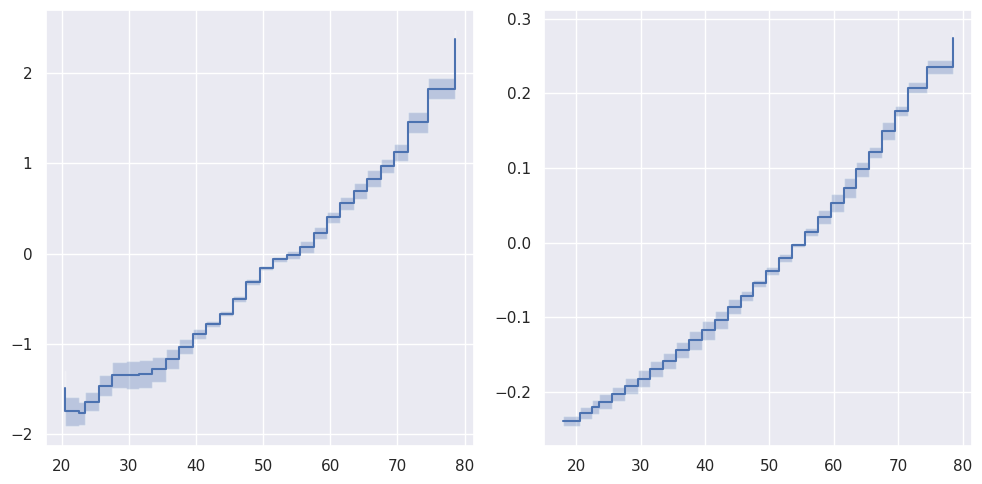

In [9]:
dataset = "heart_failure_binary"
seed = 10
col = "age"

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

dnam_shape_data = get_shape_fn_discrete_nam(col, dataset, seed)
ebm_shape_data = get_shape_fn_ebm(col, dataset, seed)

dnam_groupby = dnam_shape_data.groupby("feature_value")["feature_score"]
axes[0].plot(dnam_groupby.mean().index, dnam_groupby.mean(), drawstyle='steps-post')
axes[0].fill_between(
    dnam_groupby.mean().index,
    dnam_groupby.mean() - 1.96 * dnam_groupby.sem(),
    dnam_groupby.mean() + 1.96 * dnam_groupby.sem(),
    alpha=0.3,
    step='post'
)

axes[1].plot(ebm_shape_data["names"][:-1], ebm_shape_data["scores"], drawstyle='steps-post')
axes[1].fill_between(
    ebm_shape_data["names"][:-1],
    ebm_shape_data["lower_bounds"],
    ebm_shape_data["upper_bounds"],
    alpha=0.3,
    step='post'
)

plt.tight_layout()

SPLIT 1
SPLIT 2
SPLIT 3
SPLIT 4
SPLIT 5


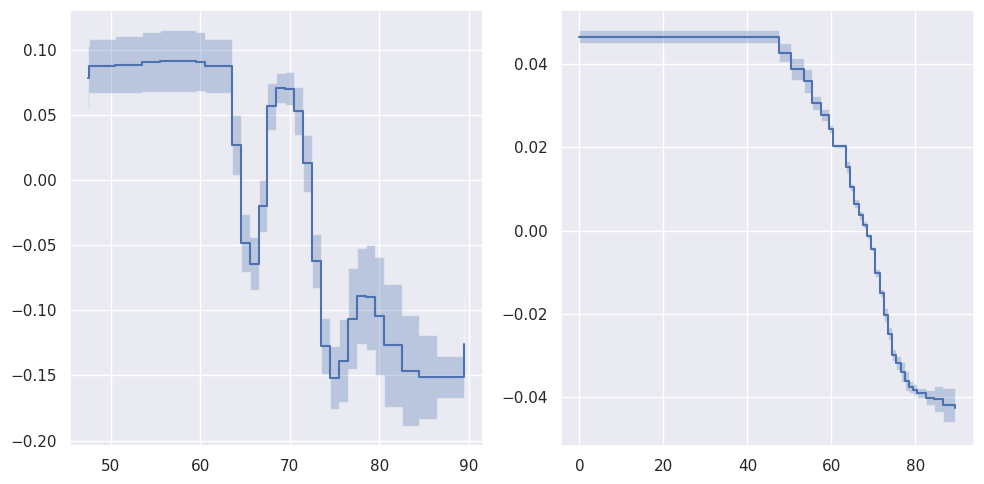

In [11]:
dataset = "heart_failure_binary"
seed = 10
col = "min:4154790_8876"

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

dnam_shape_data = get_shape_fn_discrete_nam(col, dataset, seed)
ebm_shape_data = get_shape_fn_ebm(col, dataset, seed)

dnam_groupby = dnam_shape_data.groupby("feature_value")["feature_score"]
axes[0].plot(dnam_groupby.mean().index, dnam_groupby.mean(), drawstyle='steps-post')
axes[0].fill_between(
    dnam_groupby.mean().index,
    dnam_groupby.mean() - 1.96 * dnam_groupby.sem(),
    dnam_groupby.mean() + 1.96 * dnam_groupby.sem(),
    alpha=0.3,
    step='post'
)

axes[1].plot(ebm_shape_data["names"][:-1], ebm_shape_data["scores"], drawstyle='steps-post')
axes[1].fill_between(
    ebm_shape_data["names"][:-1],
    ebm_shape_data["lower_bounds"],
    ebm_shape_data["upper_bounds"],
    alpha=0.3,
    step='post'
)

plt.tight_layout()

SPLIT 1
SPLIT 2
SPLIT 3
SPLIT 4
SPLIT 5


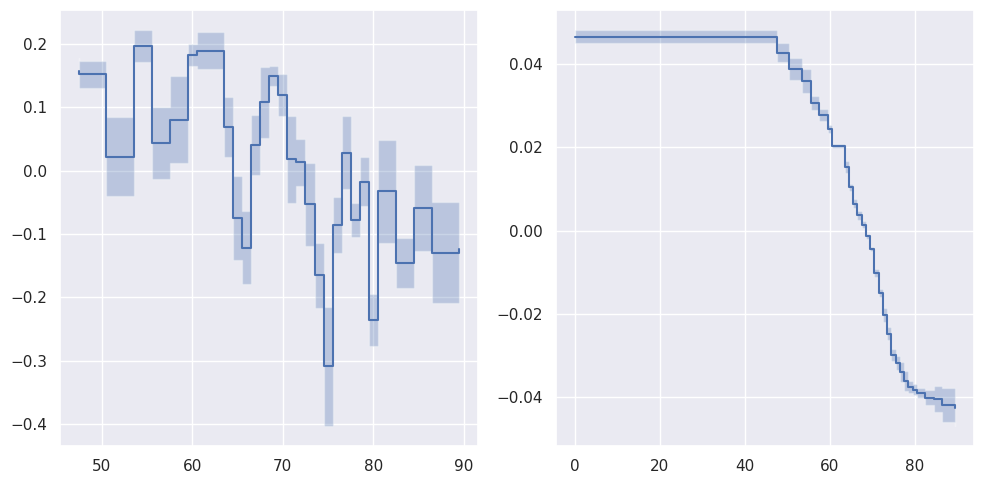

In [15]:
## Using Kernel WEight of 0

dataset = "heart_failure_binary"
seed = 10
col = "min:4154790_8876"

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

dnam_shape_data = get_shape_fn_discrete_nam(col, dataset, seed)
ebm_shape_data = get_shape_fn_ebm(col, dataset, seed)

dnam_groupby = dnam_shape_data.groupby("feature_value")["feature_score"]
axes[0].plot(dnam_groupby.mean().index, dnam_groupby.mean(), drawstyle='steps-post')
axes[0].fill_between(
    dnam_groupby.mean().index,
    dnam_groupby.mean() - 1.96 * dnam_groupby.sem(),
    dnam_groupby.mean() + 1.96 * dnam_groupby.sem(),
    alpha=0.3,
    step='post'
)

axes[1].plot(ebm_shape_data["names"][:-1], ebm_shape_data["scores"], drawstyle='steps-post')
axes[1].fill_between(
    ebm_shape_data["names"][:-1],
    ebm_shape_data["lower_bounds"],
    ebm_shape_data["upper_bounds"],
    alpha=0.3,
    step='post'
)

plt.tight_layout()

SPLIT
SPLIT
SPLIT
SPLIT
SPLIT


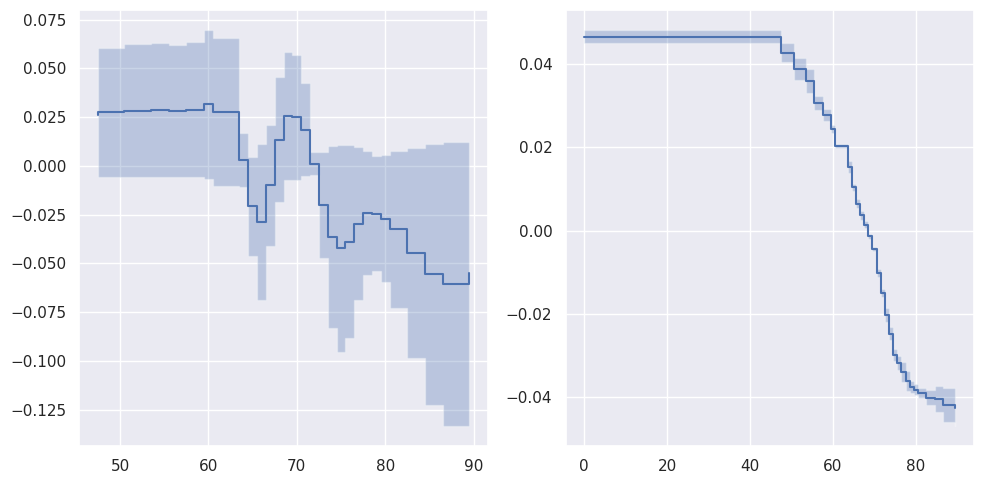

In [92]:
dataset = "heart_failure_binary"
seed = 10
col = "min:4154790_8876"

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

dnam_shape_data = get_shape_fn_discrete_nam(col, dataset, seed)
ebm_shape_data = get_shape_fn_ebm(col, dataset, seed, split)

dnam_groupby = dnam_shape_data.groupby("feature_value")["feature_score"]
axes[0].plot(dnam_groupby.mean().index, dnam_groupby.mean(), drawstyle='steps-post')
axes[0].fill_between(
    dnam_groupby.mean().index,
    dnam_groupby.mean() - 1.96 * dnam_groupby.sem(),
    dnam_groupby.mean() + 1.96 * dnam_groupby.sem(),
    alpha=0.3,
    step='post'
)

axes[1].plot(ebm_shape_data["names"][:-1], ebm_shape_data["scores"], drawstyle='steps-post')
axes[1].fill_between(
    ebm_shape_data["names"][:-1],
    ebm_shape_data["lower_bounds"],
    ebm_shape_data["upper_bounds"],
    alpha=0.3,
    step='post'
)

plt.tight_layout()

SPLIT
SPLIT
SPLIT
SPLIT
SPLIT


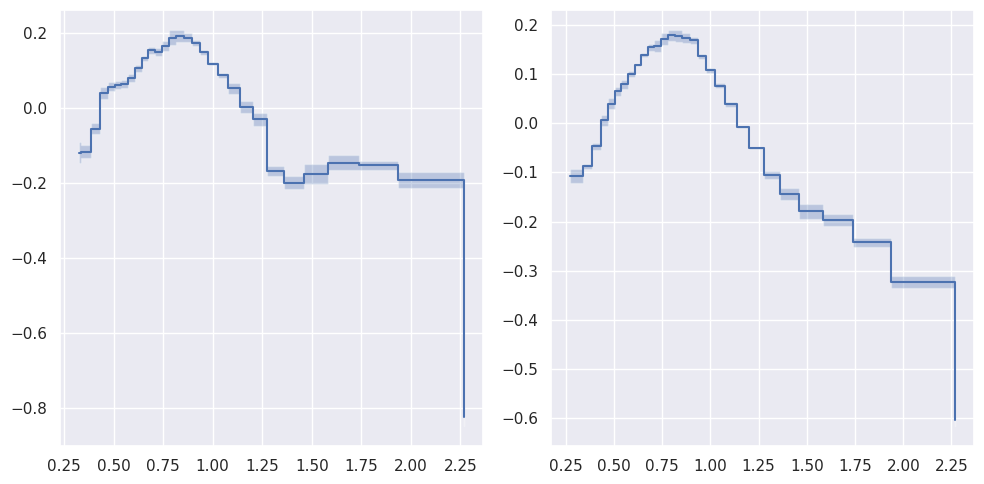

In [94]:
dataset = "higgs"
seed = 10
col = "lepton_pT"

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

dnam_shape_data = get_shape_fn_discrete_nam(col, dataset, seed)
ebm_shape_data = get_shape_fn_ebm(col, dataset, seed, split)

dnam_groupby = dnam_shape_data.groupby("feature_value")["feature_score"]
axes[0].plot(dnam_groupby.mean().index, dnam_groupby.mean(), drawstyle='steps-post')
axes[0].fill_between(
    dnam_groupby.mean().index,
    dnam_groupby.mean() - 1.96 * dnam_groupby.sem(),
    dnam_groupby.mean() + 1.96 * dnam_groupby.sem(),
    alpha=0.3,
    step='post'
)

axes[1].plot(ebm_shape_data["names"][:-1], ebm_shape_data["scores"], drawstyle='steps-post')
axes[1].fill_between(
    ebm_shape_data["names"][:-1],
    ebm_shape_data["lower_bounds"],
    ebm_shape_data["upper_bounds"],
    alpha=0.3,
    step='post'
)

plt.tight_layout()

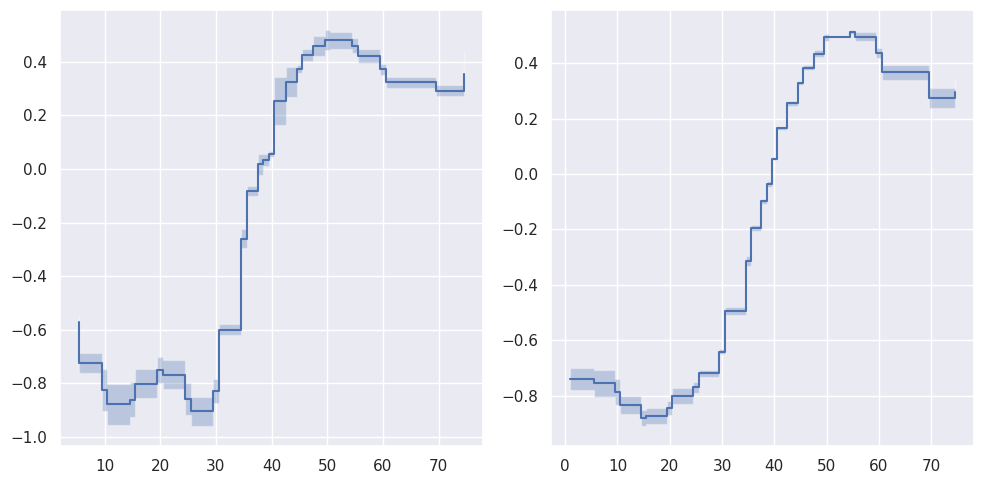

In [14]:
dataset = "adult"
seed = 10
col = "hours-per-week"

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

dnam_shape_data = get_shape_fn_discrete_nam(col, dataset, seed)
ebm_shape_data = get_shape_fn_ebm(col, dataset, seed)

dnam_groupby = dnam_shape_data.groupby("feature_value")["feature_score"]
axes[0].plot(dnam_groupby.mean().index, dnam_groupby.mean(), drawstyle='steps-post')
axes[0].fill_between(
    dnam_groupby.mean().index,
    dnam_groupby.mean() - 1.96 * dnam_groupby.sem(),
    dnam_groupby.mean() + 1.96 * dnam_groupby.sem(),
    alpha=0.3,
    step='post'
)

axes[1].plot(ebm_shape_data["names"][:-1], ebm_shape_data["scores"], drawstyle='steps-post')
axes[1].fill_between(
    ebm_shape_data["names"][:-1],
    ebm_shape_data["lower_bounds"],
    ebm_shape_data["upper_bounds"],
    alpha=0.3,
    step='post'
)

plt.tight_layout()

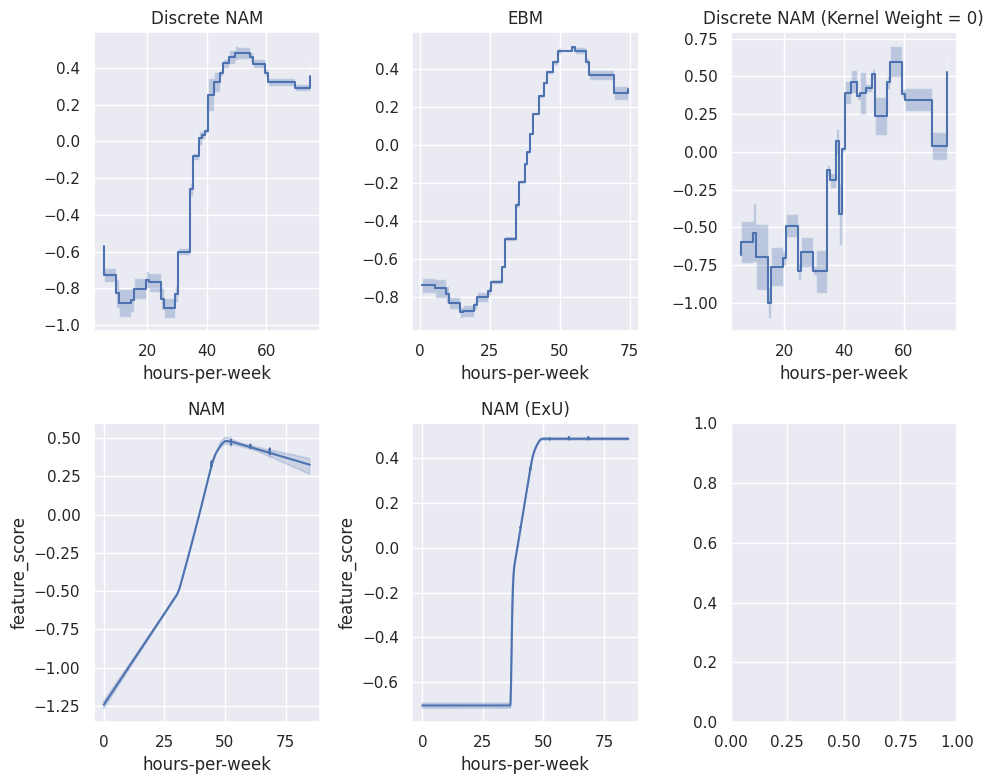

In [10]:
dataset = "adult"
seed = 10
col = "hours-per-week"

fig, axes = plt.subplots(2, 3, figsize=(10, 8))

dnam_shape_data = get_shape_fn_discrete_nam(col, dataset, seed)
dnam_kw0_shape_data = get_shape_fn_discrete_nam(col, dataset, seed, kw0=True)
nam_shape_data = get_shape_fn_nam(col, dataset, seed, feat_min=0, feat_max=85)
nam_exu_shape_data = get_shape_fn_nam(col, dataset, seed, exu=True, feat_min=0, feat_max=85)
ebm_shape_data = get_shape_fn_ebm(col, dataset, seed)

dnam_groupby = dnam_shape_data.groupby("feature_value")["feature_score"]
axes[0, 0].plot(dnam_groupby.mean().index, dnam_groupby.mean(), drawstyle='steps-post')
axes[0, 0].fill_between(
    dnam_groupby.mean().index,
    dnam_groupby.mean() - 1.96 * dnam_groupby.sem(),
    dnam_groupby.mean() + 1.96 * dnam_groupby.sem(),
    alpha=0.3,
    step='post'
)
axes[0, 0].set_xlabel(col)
axes[0, 0].set_title("Discrete NAM")

axes[0, 1].plot(ebm_shape_data["names"][:-1], ebm_shape_data["scores"], drawstyle='steps-post')
axes[0, 1].fill_between(
    ebm_shape_data["names"][:-1],
    ebm_shape_data["lower_bounds"],
    ebm_shape_data["upper_bounds"],
    alpha=0.3,
    step='post'
)
axes[0, 1].set_xlabel(col)
axes[0, 1].set_title("EBM")

dnam_kw0_groupby = dnam_kw0_shape_data.groupby("feature_value")["feature_score"]
axes[0, 2].plot(dnam_kw0_groupby.mean().index, dnam_kw0_groupby.mean(), drawstyle='steps-post')
axes[0, 2].fill_between(
    dnam_kw0_groupby.mean().index,
    dnam_kw0_groupby.mean() - 1.96 * dnam_kw0_groupby.sem(),
    dnam_kw0_groupby.mean() + 1.96 * dnam_kw0_groupby.sem(),
    alpha=0.3,
    step='post'
)
axes[0, 2].set_xlabel(col)
axes[0, 2].set_title("Discrete NAM (Kernel Weight = 0)")

sns.lineplot(data=nam_shape_data, x="feature_value", y="feature_score", ax=axes[1, 0], errorbar="ci")
axes[1, 0].set_xlabel(col)
axes[1, 0].set_title("NAM")

sns.lineplot(data=nam_exu_shape_data, x="feature_value", y="feature_score", ax=axes[1, 1], errorbar="ci")
axes[1, 1].set_xlabel(col)
axes[1, 1].set_title("NAM (ExU)")

plt.tight_layout()
plt.savefig("shape_fn_comparison.png")

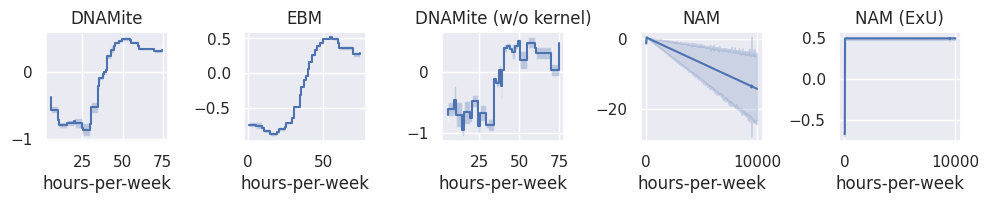

In [9]:
dataset = "adult"
seed = 10
col = "hours-per-week"

fig, axes = plt.subplots(1, 5, figsize=(10, 2))

dnam_shape_data = get_shape_fn_discrete_nam(col, dataset, seed)
dnam_kw0_shape_data = get_shape_fn_discrete_nam(col, dataset, seed, kw0=True)
nam_shape_data = get_shape_fn_nam(col, dataset, seed, feat_min=0, feat_max=10000)
nam_exu_shape_data = get_shape_fn_nam(col, dataset, seed, exu=True, feat_min=0, feat_max=10000)
ebm_shape_data = get_shape_fn_ebm(col, dataset, seed)

dnam_groupby = dnam_shape_data.groupby("feature_value")["feature_score"]
axes[0].plot(dnam_groupby.mean().index, dnam_groupby.mean(), drawstyle='steps-post')
axes[0].fill_between(
    dnam_groupby.mean().index,
    dnam_groupby.mean() - 1.96 * dnam_groupby.sem(),
    dnam_groupby.mean() + 1.96 * dnam_groupby.sem(),
    alpha=0.3,
    step='post'
)
axes[0].set_xlabel(col)
axes[0].set_title("DNAMite")
axes[0].set_ylabel("")

axes[1].plot(ebm_shape_data["names"][:-1], ebm_shape_data["scores"], drawstyle='steps-post')
axes[1].fill_between(
    ebm_shape_data["names"][:-1],
    ebm_shape_data["lower_bounds"],
    ebm_shape_data["upper_bounds"],
    alpha=0.3,
    step='post'
)
axes[1].set_xlabel(col)
axes[1].set_title("EBM")
axes[1].set_ylabel("")

dnam_kw0_groupby = dnam_kw0_shape_data.groupby("feature_value")["feature_score"]
axes[2].plot(dnam_kw0_groupby.mean().index, dnam_kw0_groupby.mean(), drawstyle='steps-post')
axes[2].fill_between(
    dnam_kw0_groupby.mean().index,
    dnam_kw0_groupby.mean() - 1.96 * dnam_kw0_groupby.sem(),
    dnam_kw0_groupby.mean() + 1.96 * dnam_kw0_groupby.sem(),
    alpha=0.3,
    step='post'
)
axes[2].set_xlabel(col)
axes[2].set_title("DNAMite (w/o kernel)")
axes[2].set_ylabel("")

sns.lineplot(data=nam_shape_data, x="feature_value", y="feature_score", ax=axes[3], errorbar="ci")
axes[3].set_xlabel(col)
axes[3].set_title("NAM")
axes[3].set_ylabel("")

sns.lineplot(data=nam_exu_shape_data, x="feature_value", y="feature_score", ax=axes[4], errorbar="ci")
axes[4].set_xlabel(col)
axes[4].set_title("NAM (ExU)")
axes[4].set_ylabel("")

plt.tight_layout(pad=0.5)
plt.savefig(f"figures/shape_fn_{col}.pdf")

In [13]:
nam_shape_data["feature_value"].value_counts().sort_index()

feature_value
49999.984375     1
50000.000000     3
50000.015625     1
50350.328125     1
50350.343750     2
                ..
398948.968750    1
399299.312500    5
399649.625000    2
399649.656250    3
400000.000000    5
Name: count, Length: 2100, dtype: int64

## Get Feature Importances

In [52]:
def get_importances_discrete_nam_(dataset, seed, split, kw0=False):
    
    # Read in model
    
    if kw0:
        model = torch.load(f"../model_saves/discrete_nam_{dataset}_seed{seed}_split{split}_kw0.pt")
    else:
        model = torch.load(f"../model_saves/discrete_nam_{dataset}_seed{seed}_split{split}.pt")
    
    # Read in args using yaml
    args_id = model.params_id
    with open(f"../run_parameters/discrete_nam_{dataset}_seed{seed}_split{split}_params{args_id}.yaml", "r") as f:
        args = yaml.safe_load(f)
    
    
    data_dict = \
        get_discetized_run_data(dataset, seed=seed, split=split, max_bins=args["max_bins"], use_feature_set=False)
        
    X_train_discrete = data_dict["X_train_discrete"]
    n_bins = data_dict["n_bins"]
    feature_bins = data_dict["feature_bins"]
    
    bin_counts = [
        get_bin_counts(X_train_discrete[col], nb) for col, nb in zip(X_train_discrete.columns, n_bins)
    ]
    
    model.compute_intercept(bin_counts)
    
    pairs_list = model.pairs_list.cpu().numpy()
    
    pair_bin_counts = [
        get_pair_bin_counts(X_train_discrete.iloc[:, col1], X_train_discrete.iloc[:, col2]) 
        for col1, col2 in pairs_list
    ]

    model.compute_pairs_intercept(pair_bin_counts)
    
    importances = []
    for i, col in enumerate(X_train_discrete.columns):
        feat_bin_scores = model.get_bin_scores(feat_index=i, center=True).squeeze(-1).cpu().numpy()
        
        feat_importance = np.sum(np.abs(feat_bin_scores) * bin_counts[i]) / np.sum(bin_counts[i])
        importances.append([col, feat_importance, len(feat_bin_scores)])
        
    for i, pair in enumerate(pairs_list):
        pair_bin_scores = model.get_pair_bin_scores(pair_index=i, center=True).squeeze(-1).cpu().numpy()
        
        pair_importance = np.sum(np.abs(pair_bin_scores) * pair_bin_counts[i]) / np.sum(pair_bin_counts[i])
        importances.append([f"{X_train_discrete.columns[pair[0]]} || {X_train_discrete.columns[pair[1]]}", pair_importance, len(pair_bin_scores)])
        
    return pd.DataFrame(importances, columns=["feature", "importance", "n_bins"])

In [86]:
def get_importances_ebm(dataset, seed):
    
    # Read in model
    with open(f"../model_saves/ebm_{dataset}_seed{seed}.pkl", "rb") as f:
        ebm = pickle.load(f)
    
    return pd.DataFrame({
        "Feature": ebm.term_names_,
        "importance": ebm.term_importances()
    })

In [53]:
dataset = "adult"
seed = 10
split = 1

importances = get_importances_discrete_nam_(dataset, seed, split, kw0=False)
importances.sort_values("importance", ascending=False).iloc[:50]

,feature,importance,n_bins
2,marital-status,1.208818,8
11,capital-gain,0.796016,25
3,occupation,0.788667,15
8,age,0.697836,31
10,education-num,0.385506,15
0,workclass,0.356456,9
13,hours-per-week,0.283674,31
1,education,0.257499,16
4,relationship,0.212527,7
12,capital-loss,0.161052,25


In [87]:
dataset = "adult"
seed = 10
split = 1

importances = get_importances_ebm(dataset, seed)
importances.sort_values("importance", ascending=False)

,Feature,importance
0,age,0.685948
5,marital-status,0.628051
7,relationship,0.549393
4,education-num,0.473403
10,capital-gain,0.451935
12,hours-per-week,0.292573
6,occupation,0.244534
9,sex,0.233130
3,education,0.142517
17,age & capital-loss,0.140240


## Get Interaction Plots

In [22]:
def make_grid(x, y):
    grid = np.meshgrid(x, y, indexing="ij")
    grid = np.stack(grid, axis=-1)
    return grid.reshape(-1, 2)

In [155]:
def get_pair_fn_discrete_nam_(col1, col2, dataset, seed, split, kw0=False, pkw=False):
    
    # Read in model
    
    if kw0:
        model = torch.load(f"../model_saves/discrete_nam_{dataset}_seed{seed}_split{split}_kw0.pt")
    elif pkw:
        model = torch.load(f"../model_saves/discrete_nam_{dataset}_seed{seed}_split{split}.pt")
    else:
        model = torch.load(f"../model_saves/discrete_nam_{dataset}_seed{seed}_split{split}.pt")
    
    # Read in args using yaml
    args_id = model.params_id
    with open(f"../run_parameters/discrete_nam_{dataset}_seed{seed}_split{split}_params{args_id}.yaml", "r") as f:
        args = yaml.safe_load(f)
    
    
    data_dict = \
        get_discetized_run_data(dataset, seed=seed, split=split, max_bins=args["max_bins"], use_feature_set=False)
        
    X_train_discrete = data_dict["X_train_discrete"]
    n_bins = data_dict["n_bins"]
    feature_bins = data_dict["feature_bins"]
    
    pairs_list = model.pairs_list.cpu().numpy()
    
    col1_index = X_train_discrete.columns.get_loc(col1)
    col2_index = X_train_discrete.columns.get_loc(col2)
        
    pair_bin_counts = [
        get_pair_bin_counts(X_train_discrete.iloc[:, col1], X_train_discrete.iloc[:, col2]) 
        for col1, col2 in pairs_list
    ]

    model.compute_pairs_intercept(pair_bin_counts)
    
    pair_index = [
        i for i, p in enumerate(pairs_list) if (p[0] == col1_index and p[1] == col2_index) or (p[0] == col2_index and p[1] == col1_index)
    ]
    
    if len(pair_index) == 0:
        raise ValueError("Pair not found")
    
    pair_index = pair_index[0]

    pair_bin_scores = model.get_pair_bin_scores(pair_index, center=True).squeeze(-1).cpu().numpy()

    grid = make_grid(np.arange(0, n_bins[col1_index]), np.arange(0, n_bins[col2_index]))
    pair_bin_scores = pair_bin_scores[grid.prod(axis=1) > 0]

    # Get bin values
    feat1_bin_values = np.concatenate([
        [feature_bins[col1_index].min() - 0.01],
        feature_bins[col1_index]
    ])
    feat2_bin_values = np.concatenate([
        [feature_bins[col2_index].min() - 0.01],
        feature_bins[col2_index]
    ])

    pair_bin_values = make_grid(feat1_bin_values, feat2_bin_values)
    
    return model, pair_bin_values, pair_bin_scores

In [96]:
def get_pair_fn_nam_(col1, col2, dataset, seed, split, feat1_min=None, feat1_max=None, feat2_min=None, feat2_max=None, exu=False):
    # Read in model
    model = torch.load(f"../model_saves/nam_exu{exu}_{dataset}_seed{seed}_split{split}.pt")
        
    # Read in args using yaml
    args_id = model.params_id
    with open(f"../run_parameters/nam_exu{exu}_{dataset}_seed{seed}_split{split}_params{args_id}.yaml", "r") as f:
        args = yaml.safe_load(f)
    
    
    data_dict = get_run_data(dataset, split=split, preprocess=True)
    X_train = data_dict["X_train"]
    y_train = data_dict["y_train"]
    preprocessor = data_dict["preprocessor"]
    
    pairs_list = model.pairs_list.cpu().numpy()
    X_train_interactions = X_train.values[:, pairs_list]
    
    batch_size = args["batch_size"]
    train_dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(X_train.values), 
        torch.FloatTensor(X_train_interactions),
        torch.FloatTensor(y_train),
    )
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
    model.compute_pair_intercept(train_loader)
    
    col1_index = X_train.columns.get_loc(col1)
    col2_index = X_train.columns.get_loc(col2)
    
    pair_index = [
        i for i, p in enumerate(pairs_list) if (p[0] == col1_index and p[1] == col2_index) or (p[0] == col2_index and p[1] == col1_index)
    ]
    
    if len(pair_index) == 0:
        raise ValueError("Pair not found")
    
    pair_index = pair_index[0]
    
    feature_scales = pd.DataFrame({
        "feat": preprocessor.transformers_[1][1][0].feature_names_in_,
        "mean": preprocessor.transformers_[1][1][0].mean_,
        "scale": preprocessor.transformers_[1][1][0].scale_
    })
    feat1_mean = feature_scales.loc[feature_scales["feat"] == col1, "mean"].values[0]
    feat1_std = feature_scales.loc[feature_scales["feat"] == col1, "scale"].values[0]
    
    feat2_mean = feature_scales.loc[feature_scales["feat"] == col2, "mean"].values[0]
    feat2_std = feature_scales.loc[feature_scales["feat"] == col2, "scale"].values[0]
    
    if feat1_min is None and feat1_max is None:
        feat1_min = -3
        feat1_max = 3
        feat2_mean = -3
        feat2_max = 3
    else:
        feat1_min = (feat1_min - feat1_mean) / feat1_std
        feat1_max = (feat1_max - feat1_mean) / feat1_std
        feat2_min = (feat2_min - feat2_mean) / feat2_std
        feat2_max = (feat2_max - feat2_mean) / feat2_std

    with torch.no_grad():
        pair_preds, pair_inputs = model.get_interaction_function(pair_index, feat1_min, feat1_max, feat2_min, feat2_max, center=True)
        
    pair_inputs[:, 0] = pair_inputs[:, 0] * feat1_std + feat1_mean
    pair_inputs[:, 1] = pair_inputs[:, 1] * feat2_std + feat2_mean
    
    return pair_inputs.cpu().numpy().round(4), pair_preds.squeeze().cpu().numpy()

In [113]:
def get_pair_fn_ebm(col1, col2, dataset, seed, split=1):
    
    # Read in model
    with open(f"../model_saves/ebm_{dataset}_seed{seed}.pkl", "rb") as f:
        ebm = pickle.load(f)
    
    
    data_dict = get_run_data(dataset, seed=seed, split=split, preprocess=False)
    X_train = data_dict["X_train"]
    
    feat_idx = X_train.columns.get_loc(col)

    ebm_global = ebm.explain_global()
    
    pair_idx = [
        i for i, p in enumerate(ebm.term_names_) if "&" in p and (
            (p.split(" & ")[0] == col1 and p.split(" & ")[1] == col2) \
            or (p.split(" & ")[0] == col2 and p.split(" & ")[1] == col1)
        )
    ]
    
    if len(pair_idx) == 0:
        raise ValueError("Pair not found")
    
    pair_idx = pair_idx[0]
    
    shape_data = ebm_global.data(pair_idx)
    
    return shape_data

In [33]:
# Read in model
with open(f"../model_saves/ebm_{dataset}_seed{seed}.pkl", "rb") as f:
    ebm = pickle.load(f)


data_dict = get_run_data(dataset, seed=seed, split=split, preprocess=False)
X_train = data_dict["X_train"]

feat_idx = X_train.columns.get_loc(col)

ebm_global = ebm.explain_global()

In [54]:
[
    (i, p.split(" & ")) for i, p in enumerate(ebm.term_names_) if "&" in p
]

[(14, ['age', 'education-num']),
 (15, ['age', 'race']),
 (16, ['age', 'capital-gain']),
 (17, ['age', 'capital-loss']),
 (18, ['workclass', 'education-num']),
 (19, ['workclass', 'capital-loss']),
 (20, ['fnlwgt', 'capital-gain']),
 (21, ['education', 'capital-gain']),
 (22, ['education-num', 'capital-gain']),
 (23, ['marital-status', 'occupation']),
 (24, ['marital-status', 'capital-gain']),
 (25, ['marital-status', 'capital-loss']),
 (26, ['marital-status', 'hours-per-week']),
 (27, ['occupation', 'relationship']),
 (28, ['occupation', 'capital-gain']),
 (29, ['occupation', 'capital-loss']),
 (30, ['relationship', 'capital-gain']),
 (31, ['relationship', 'capital-loss']),
 (32, ['relationship', 'hours-per-week']),
 (33, ['capital-gain', 'hours-per-week'])]

In [ ]:
dataset = "adult"
seed = 10
split = 1
# col1 = "fnlwgt"
# col2 = "capital-gain"
col1 = "capital-loss"
col2 = "hours-per-week"

model = torch.load(f"../model_saves/discrete_nam_{dataset}_seed{seed}_split{split}.pt")

data_dict = \
    get_discetized_run_data(dataset, seed=seed, split=split, max_bins=32, use_feature_set=False)
    
X_train_discrete = data_dict["X_train_discrete"]
n_bins = data_dict["n_bins"]
feature_bins = data_dict["feature_bins"]

pairs_list = model.pairs_list.cpu().numpy()

col1_index = X_train_discrete.columns.get_loc(col1)
col2_index = X_train_discrete.columns.get_loc(col2)
    
pair_bin_counts = [
    get_pair_bin_counts(X_train_discrete.iloc[:, col1], X_train_discrete.iloc[:, col2]) 
    for col1, col2 in pairs_list
]

model.compute_pairs_intercept(pair_bin_counts)

pair_bin_scores = model.get_pair_bin_scores(pair_index=0, center=True).squeeze(-1).cpu().numpy()

In [70]:
data_dict = \
    get_discetized_run_data(dataset, seed=seed, split=split, max_bins=32, use_feature_set=False)

In [71]:
ord_encoder = data_dict["preprocessor"].transformers_[0][1]
col = "occupation"
col_index = np.where(ord_encoder.feature_names_in_ == col)[0][0]
categories = ord_encoder.categories_[col_index]

for i, cat in enumerate(categories):
    print(f"{col} = {cat}: {i}")

occupation = Adm-clerical: 0
occupation = Armed-Forces: 1
occupation = Craft-repair: 2
occupation = Exec-managerial: 3
occupation = Farming-fishing: 4
occupation = Handlers-cleaners: 5
occupation = Machine-op-inspct: 6
occupation = Other-service: 7
occupation = Priv-house-serv: 8
occupation = Prof-specialty: 9
occupation = Protective-serv: 10
occupation = Sales: 11
occupation = Tech-support: 12
occupation = Transport-moving: 13
occupation = nan: 14


In [44]:
data_dict["preprocessor"].inverse_transform(data_dict["X_train"])

AttributeError: 'NoneType' object has no attribute 'inverse_transform'

In [200]:
dataset = "adult"
# dataset = "churn"
# dataset = "housing"
# dataset = "miniboone"
# dataset = "higgs"
seed = 10
split = 1
# col1 = "fnlwgt"
# col2 = "capital-gain"
# col1 = "capital-loss"
# col2 = "hours-per-week"
col1 = "age"
col2 = "education-num"
# col1 = "marital-status"
# col2 = "occupation"
# col1 = "relationship"
# col2 = "hours-per-week"
# col1 = "age"
# col2 = "fnlwgt"
# col1 = "MonthlyCharges"
# col2 = "TotalCharges"
# col1 = "Latitude"
# col2 = "Longitude"
# col1 = "HouseAge"
# col2 = "AveOccup"
# col1 = "ParticleID_25"
# col2 = "ParticleID_26"
# col1 = "m_bb"
# col2 = "m_wbb"
# col1 = "m_jjj"
# col2 = "m_jlv"


model, pair_bin_values, pair_bin_scores = get_pair_fn_discrete_nam_(col1, col2, dataset, seed, split, kw0=False, pkw=True)

In [166]:
model.pairs_intercept

tensor([0.0895], device='cuda:0')

<Axes: xlabel='education-num', ylabel='age'>

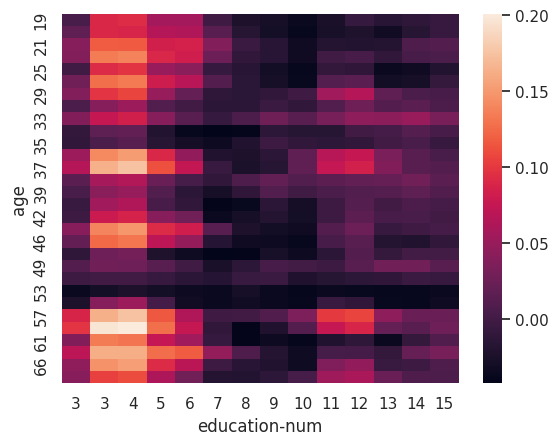

In [201]:
pair_data_dnam = pd.DataFrame({
    col1: pair_bin_values[:, 0],
    col2: pair_bin_values[:, 1],
    "score": pair_bin_scores
})

pair_data_dnam = pair_data_dnam.pivot(
    index=col1, 
    columns=col2, 
    values="score"
)

# Round the values in the columns and index
pair_data_dnam.columns = pair_data_dnam.columns.astype(int).round()
pair_data_dnam.index = pair_data_dnam.index.astype(int).round()

sns.heatmap(pair_data_dnam)

In [202]:
dataset = "adult"
# dataset = "churn"
# dataset = "housing"
# dataset = "miniboone"
# dataset = "higgs"
seed = 10
split = 1
# col1 = "fnlwgt"
# col2 = "capital-gain"
# col1 = "capital-loss"
# col2 = "hours-per-week"
col1 = "age"
col2 = "education-num"
# col1 = "marital-status"
# col2 = "occupation"
# col1 = "relationship"
# col2 = "hours-per-week"
# col1 = "age"
# col2 = "fnlwgt"
# col1 = "MonthlyCharges"
# col2 = "TotalCharges"
# col1 = "Latitude"
# col2 = "Longitude"
# col1 = "HouseAge"
# col2 = "AveOccup"
# col1 = "ParticleID_25"
# col2 = "ParticleID_26"
# col1 = "m_bb"
# col2 = "m_wbb"
# col1 = "m_jjj"
# col2 = "m_jlv"


model, pair_bin_values, pair_bin_scores = get_pair_fn_discrete_nam_(col1, col2, dataset, seed, split, kw0=True)

In [162]:
model.pairs_intercept

tensor([-0.0566], device='cuda:0')

<Axes: xlabel='education-num', ylabel='age'>

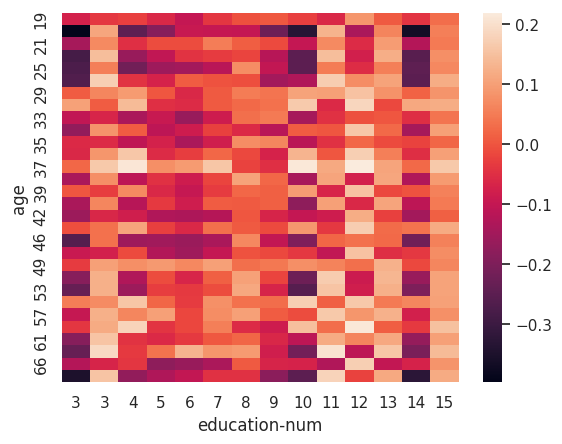

In [203]:
pair_data_dnam_kw0 = pd.DataFrame({
    col1: pair_bin_values[:, 0],
    col2: pair_bin_values[:, 1],
    "score": pair_bin_scores
})

pair_data_dnam_kw0 = pair_data_dnam_kw0.pivot(
    index=col1, 
    columns=col2, 
    values="score"
)

# Round the values in the columns and index
pair_data_dnam_kw0.columns = pair_data_dnam_kw0.columns.astype(int).round()
pair_data_dnam_kw0.index = pair_data_dnam_kw0.index.astype(int).round()

sns.heatmap(pair_data_dnam_kw0)

In [204]:
dataset = "adult"
seed = 10
split = 1
# col1 = "fnlwgt"
# col2 = "capital-gain"
# col1 = "capital-loss"
# col2 = "hours-per-week"
# col1 = "marital-status"
# col2 = "occupation"
col1 = "age"
col2 = "education-num"
# col1 = "relationship"
# col2 = "hours-per-week"

pair_data_ebm = get_pair_fn_ebm(col1, col2, dataset, seed, split)

In [205]:
pair_data_ebm_df = pd.DataFrame(
    pair_data_ebm["scores"], 
    index=pair_data_ebm["left_names"][:-1], 
    columns=pair_data_ebm["right_names"][:-1]
    # columns = pair_data_ebm["right_names"]
)

# Round the values in the columns and index
pair_data_ebm_df.columns = pair_data_ebm_df.columns.astype(int).round()
pair_data_ebm_df.index = pair_data_ebm_df.index.astype(int).round()

<Axes: >

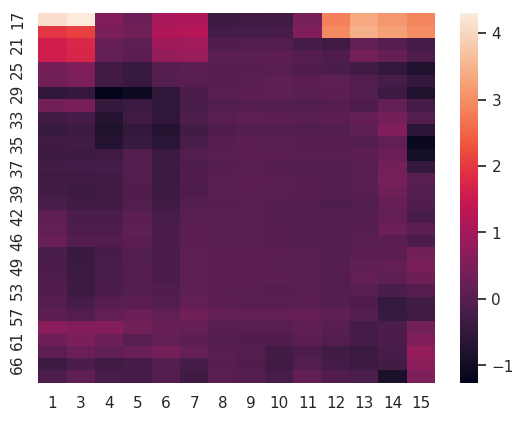

In [206]:
sns.heatmap(pair_data_ebm_df)

In [64]:
data_dict = get_run_data(dataset="adult", seed=10, split=1, preprocess=True)
model = torch.load(f"../model_saves/nam_exuFalse_adult_seed10_split1.pt")
pairs_list = model.pairs_list.cpu().numpy()

X_train = data_dict["X_train"]
for pair in pairs_list:
    print(X_train.columns[pair[0]], X_train.columns[pair[1]])

capital-gain hours-per-week
occupation_Exec-managerial capital-gain
education-num capital-gain
native-country_Mexico capital-gain
marital-status_Married-civ-spouse capital-gain
occupation_Farming-fishing capital-gain
fnlwgt capital-gain
age capital-gain
education_Preschool relationship_Other-relative
relationship_Wife capital-gain
education_Preschool age
education_7th-8th age
native-country_Italy age
education_Preschool hours-per-week
race_Asian-Pac-Islander capital-gain
age education-num
relationship_Not-in-family capital-gain
relationship_Husband capital-gain
marital-status_Married-civ-spouse capital-loss
relationship_Husband capital-loss


In [174]:
dataset = "adult"
# dataset = "churn"
# dataset = "housing"
# dataset = "miniboone"
# dataset = "higgs"
seed = 10
split = 1
# col1 = "fnlwgt"
# col2 = "capital-gain"
# col1 = "capital-loss"
# col2 = "hours-per-week"
# col1 = "marital-status"
# col2 = "occupation"
# col1 = "relationship"
# col2 = "hours-per-week"
# col1 = "age"
# col2 = "fnlwgt"
col1 = "age"
col2 = "education-num"
# col1 = "MonthlyCharges"
# col2 = "TotalCharges"
# col1 = "Latitude"
# col2 = "Longitude"
# col1 = "HouseAge"
# col2 = "AveOccup"
# col1 = "ParticleID_25"
# col2 = "ParticleID_26"
# col1 = "m_bb"
# col2 = "m_wbb"
# col1 = "m_jjj"
# col2 = "m_jlv"

pair_inputs, pair_preds = get_pair_fn_nam_(
    col1, col2, dataset, seed, split, feat1_min=20, feat1_max=80, feat2_min=0, feat2_max=16
)


<Axes: xlabel='education-num', ylabel='age'>

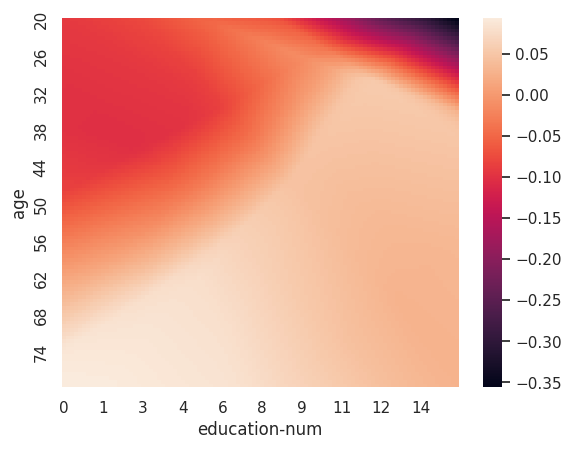

In [198]:
# pair_data = pd.DataFrame({
#     col1: pair_inputs[:, 0],
#     col2: pair_inputs[:, 1],
#     "score": pair_preds
# })

# pair_data = pair_data.pivot(
#     index=col1, 
#     columns=col2, 
#     values="score"
# )

# pair_data = pd.DataFrame(
#     pair_preds.reshape(100, 100),
#     index=np.unique(pair_inputs[:, 0]).round(),
#     columns=np.unique(pair_inputs[:, 1]).round()
# )


df_nam = pd.DataFrame({
    col1: pair_inputs[:, 0],
    col2: pair_inputs[:, 1],
    "Prediction": pair_preds
})

df_nam = df_nam.pivot(
    columns=col2, 
    index=col1, 
    values="Prediction"
)

# Round the values in the columns and index
df_nam.columns = df_nam.columns.astype(int).round()
df_nam.index = df_nam.index.astype(int).round()

sns.heatmap(df_nam, xticklabels=10, yticklabels=10)

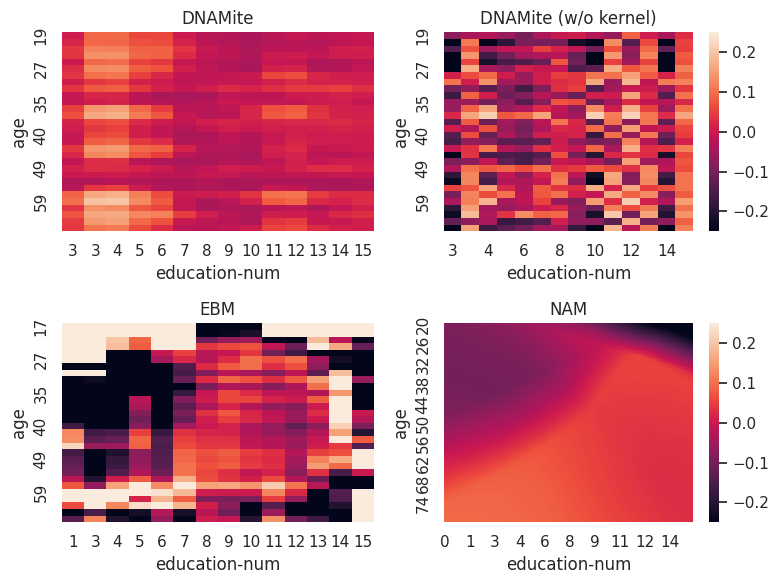

In [ ]:
# Plot all 4 models
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

sns.heatmap(pair_data_dnam, ax=axes[0, 0], yticklabels=5, vmin=-0.25, vmax=0.25, cbar=False)
axes[0, 0].set_title("DNAMite")

sns.heatmap(pair_data_dnam_kw0, ax=axes[0, 1], yticklabels=5, vmin=-0.25, vmax=0.25)
axes[0, 1].set_title("DNAMite (w/o kernel)")

sns.heatmap(pair_data_ebm_df, ax=axes[1, 0], yticklabels=5, vmin=-0.25, vmax=0.25, cbar=False)
axes[1, 0].set_title("EBM")
axes[1, 0].set_ylabel("age")
axes[1, 0].set_xlabel("education-num")

sns.heatmap(df_nam, ax=axes[1, 1], xticklabels=10, yticklabels=10, vmin=-0.25, vmax=0.25)
axes[1, 1].set_title("NAM")

plt.tight_layout()
plt.savefig("figures/interaction_plots.pdf")